## Question 1

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkTest") \
    .master("local[*]") \
    .getOrCreate()

print(spark.version)

3.5.5


## Question 2

In [ ]:
# Download parquet file
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-10.parquet


--2025-03-04 20:07:47--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-10.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.84.111.169, 52.84.111.148, 52.84.111.30, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.84.111.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64346071 (61M) [binary/octet-stream]
Saving to: 'yellow_tripdata_2024-10.parquet'

     0K .......... .......... .......... .......... ..........  0% 1.62M 38s
    50K .......... .......... .......... .......... ..........  0% 2.06M 34s
   100K .......... .......... .......... .......... ..........  0% 3.43M 28s
   150K .......... .......... .......... .......... ..........  0% 3.64M 26s
   200K .......... .......... .......... .......... ..........  0% 7.88M 22s
   250K .......... .......... .......... .......... ..........  0% 4.20M 21s
   300K .......... .......... .......... .......... .......... 

In [2]:
# Read the dataset into a Spark DataFrame
df = spark.read.parquet("yellow_tripdata_2024-10.parquet")

In [3]:
# Repartition the DataFrame into 4 partitions
df.repartition(4).write.parquet("file:///C:/Users/User/data-engineering-zoomcamp/homework_5/output/")

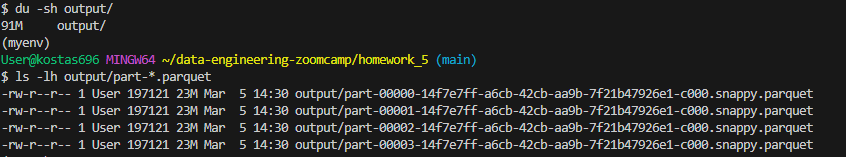

## Question 3

In [4]:
from pyspark.sql.functions import col

df_filtered = df.filter(col("tpep_pickup_datetime").startswith("2024-10-15"))
print(df_filtered.count())

128893


## Question 4

In [5]:
from pyspark.sql.functions import unix_timestamp

df = df.withColumn("trip_duration", 
                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600)

longest_trip = df.select("trip_duration").orderBy(col("trip_duration").desc()).first()
print(longest_trip["trip_duration"])

162.61777777777777


## Question 5

Spark’s UI typically runs on port 4040, so the correct answer is: 4040

## Question 6

In [ ]:
# Download dataset
!wget https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv

--2025-03-05 14:39:25--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 52.84.111.169, 52.84.111.30, 52.84.111.148, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|52.84.111.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12331 (12K) [text/csv]
Saving to: 'taxi_zone_lookup.csv'

     0K .......... ..                                         100% 1.53G=0s

2025-03-05 14:39:27 (1.53 GB/s) - 'taxi_zone_lookup.csv' saved [12331/12331]



In [7]:
# Load it into Spark
zones_df = spark.read.option("header", True).csv("taxi_zone_lookup.csv")
zones_df.createOrReplaceTempView("zones")
df.createOrReplaceTempView("trips")

In [10]:
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|       trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+--------------------+
|       2| 2024-10-01 00:30:44|  2024-10-01 00:48:26|              1|          3.0|         1|                 N|         16

In [11]:
zones_df.show(10)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 10 rows



In [8]:
query = """
SELECT z.Zone, COUNT(*) as trip_count
FROM trips t
JOIN zones z
ON t.PULocationID = z.LocationID
GROUP BY z.Zone
ORDER BY trip_count ASC
LIMIT 1
"""
result = spark.sql(query)
result.show()

+--------------------+----------+
|                Zone|trip_count|
+--------------------+----------+
|Governor's Island...|         1|
+--------------------+----------+

